<a href="https://colab.research.google.com/github/cagBRT/Data/blob/main/ReSampling_Imbalanced_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### Ensemble classifiers have shown to improve classification performance compare to single learner.

**Ensemble classifiers are affected by class imbalance.**

These examples show the benefit of balancing the training set before applying ensemble learners.

One of the ways in which you deal with imbalanced datasets is by resampling with sklearn.resample i.e. upsampling the minority class or downsampling the majority class.

klearn.resample doesn’t just generate extra data points to the datasets by magic, it basically creates a random resampling(with/without replacement) of your dataset. This equalization procedure prevents the Machine Learning model from inclining towards the majority class in the dataset.<br>

The upsampling mechanism introduces bias into your system because of the additional information.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from imblearn.datasets import fetch_datasets
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import geometric_mean_score
from sklearn.ensemble import BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier, RUSBoostClassifier

# Get an imbalanced dataset

fetch_datasets loads an imbalanced benchmark dataset from sklearn<br>
The datasets can be found [here](https://imbalanced-learn.org/stable/references/generated/imblearn.datasets.fetch_datasets.html#imblearn.datasets.fetch_datasets)

In [3]:
satimage = fetch_datasets()["satimage"]
X, y = satimage.data, satimage.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [25]:
import numpy as np
print(y.shape)
np.unique(y, return_counts=True)

(6435,)


(array([-1,  1]), array([5809,  626]))

#A Decision Tree Classifier<br>

The results are reported in terms of **balanced accuracy and geometric mean which are metrics widely used in the literature to validate model trained on imbalanced set**

In [4]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

In [5]:
print("Decision tree classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred_tree):.2f} - "
    f"Geometric mean {geometric_mean_score(y_test, y_pred_tree):.2f}"
)

Decision tree classifier performance:
Balanced accuracy: 0.75 - Geometric mean 0.72


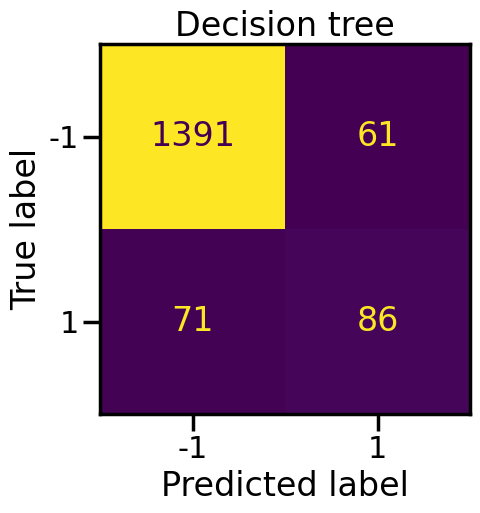

In [6]:
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

sns.set_context("poster")

disp = ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test, colorbar=False)
_ = disp.ax_.set_title("Decision tree")

# Classification using bagging classifier with and without sampling

Instead of using a single tree, we will check if an ensemble of decision tree can actually alleviate the issue induced by the class imbalancing. First, we will use a bagging classifier and its counter part which internally uses a random under-sampling to balanced each bootstrap sample.

In [7]:
bagging = BaggingClassifier(n_estimators=50, random_state=0)
balanced_bagging = BalancedBaggingClassifier(n_estimators=50, random_state=0)

bagging.fit(X_train, y_train)
balanced_bagging.fit(X_train, y_train)

y_pred_bc = bagging.predict(X_test)
y_pred_bbc = balanced_bagging.predict(X_test)

Balancing each bootstrap sample increases significantly the balanced accuracy and the geometric mean.

In [8]:
print("Bagging classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred_bc):.2f} - "
    f"Geometric mean {geometric_mean_score(y_test, y_pred_bc):.2f}"
)
print("Balanced Bagging classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred_bbc):.2f} - "
    f"Geometric mean {geometric_mean_score(y_test, y_pred_bbc):.2f}"
)

Bagging classifier performance:
Balanced accuracy: 0.73 - Geometric mean 0.68
Balanced Bagging classifier performance:
Balanced accuracy: 0.86 - Geometric mean 0.86


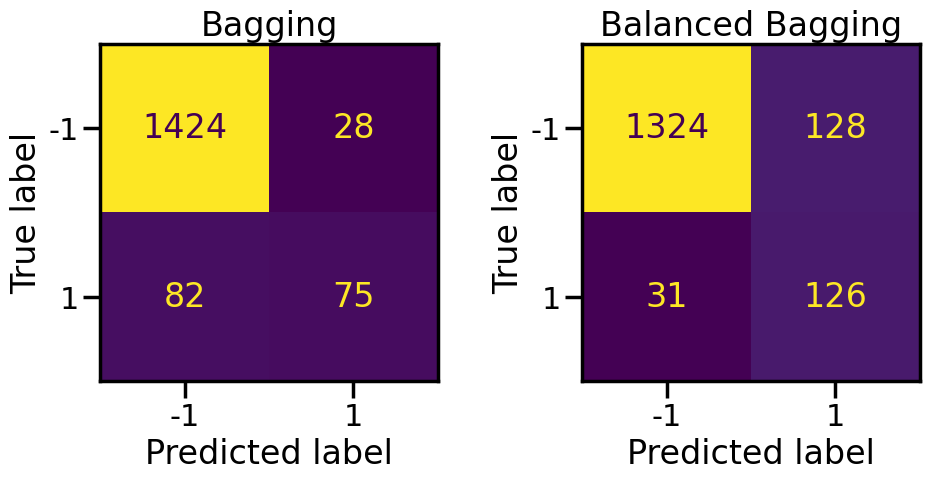

In [9]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
ConfusionMatrixDisplay.from_estimator(
    bagging, X_test, y_test, ax=axs[0], colorbar=False
)
axs[0].set_title("Bagging")

ConfusionMatrixDisplay.from_estimator(
    balanced_bagging, X_test, y_test, ax=axs[1], colorbar=False
)
axs[1].set_title("Balanced Bagging")

fig.tight_layout()

# Classification using random forest classifier with and without sampling

Random forest is another popular ensemble method and it usually outperforms bagging. <br>

Here, we used a vanilla random forest and its balanced counterpart in which each bootstrap sample is balanced.

In [10]:
import warnings
warnings.filterwarnings("ignore")

import sklearn.utils.parallel
rf = RandomForestClassifier(n_estimators=50, random_state=0)
brf = BalancedRandomForestClassifier(
    n_estimators=50, sampling_strategy="all", replacement=True, random_state=0
)

rf.fit(X_train, y_train)
brf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_pred_brf = brf.predict(X_test)

Similarly to the previous experiment, the balanced classifier outperform the classifier which learn from imbalanced bootstrap samples. In addition, random forest outperforms the bagging classifier.

In [11]:
print("Random Forest classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred_rf):.2f} - "
    f"Geometric mean {geometric_mean_score(y_test, y_pred_rf):.2f}"
)
print("Balanced Random Forest classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred_brf):.2f} - "
    f"Geometric mean {geometric_mean_score(y_test, y_pred_brf):.2f}"
)

Random Forest classifier performance:
Balanced accuracy: 0.73 - Geometric mean 0.68
Balanced Random Forest classifier performance:
Balanced accuracy: 0.87 - Geometric mean 0.86


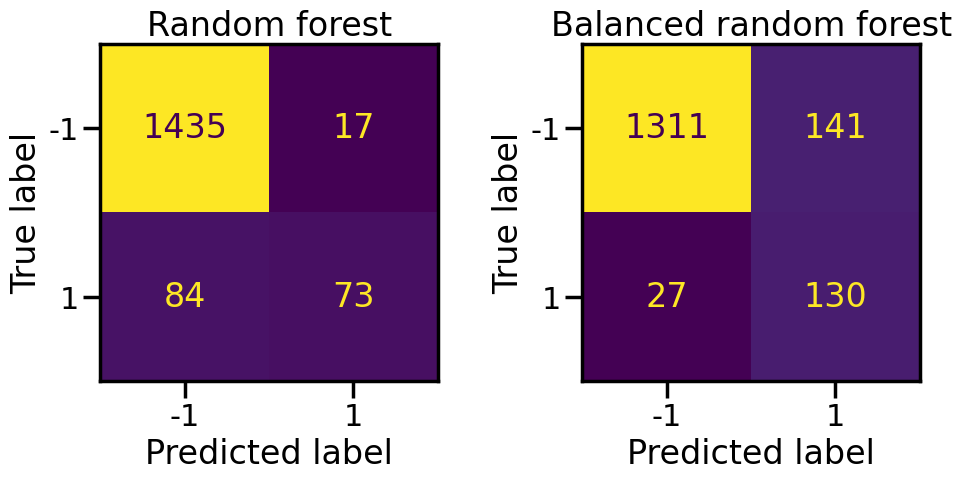

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, ax=axs[0], colorbar=False)
axs[0].set_title("Random forest")

ConfusionMatrixDisplay.from_estimator(brf, X_test, y_test, ax=axs[1], colorbar=False)
axs[1].set_title("Balanced random forest")

fig.tight_layout()

# Boosting classifier<br>

An easy ensemble classifier is a bag of balanced AdaBoost classifier.

This classifier will be slower to train than a random forest classifier and will usually have a worse performance.

In [13]:
estimator = AdaBoostClassifier(n_estimators=10)
eec = EasyEnsembleClassifier(n_estimators=10, estimator=estimator)
eec.fit(X_train, y_train)
y_pred_eec = eec.predict(X_test)

rusboost = RUSBoostClassifier(n_estimators=10, estimator=estimator)
rusboost.fit(X_train, y_train)
y_pred_rusboost = rusboost.predict(X_test)

In [14]:
print("Easy ensemble classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred_eec):.2f} - "
    f"Geometric mean {geometric_mean_score(y_test, y_pred_eec):.2f}"
)
print("RUSBoost classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred_rusboost):.2f} - "
    f"Geometric mean {geometric_mean_score(y_test, y_pred_rusboost):.2f}"
)

Easy ensemble classifier performance:
Balanced accuracy: 0.84 - Geometric mean 0.84
RUSBoost classifier performance:
Balanced accuracy: 0.85 - Geometric mean 0.85


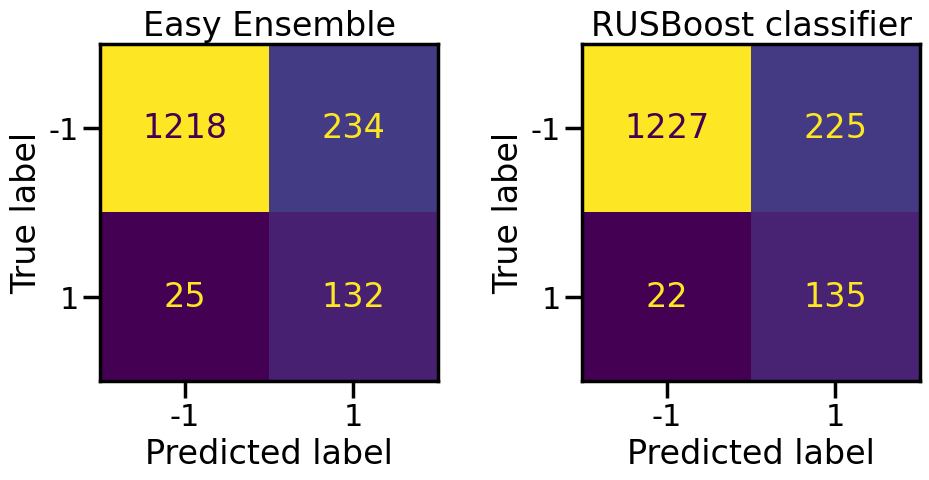

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

ConfusionMatrixDisplay.from_estimator(eec, X_test, y_test, ax=axs[0], colorbar=False)
axs[0].set_title("Easy Ensemble")
ConfusionMatrixDisplay.from_estimator(
    rusboost, X_test, y_test, ax=axs[1], colorbar=False
)
axs[1].set_title("RUSBoost classifier")

fig.tight_layout()
plt.show()